# Illustrative Notebook for Graph Counterfactual Explainations

**Disclaimer: This notebook is designed purely for illustrative purposes. The code and explanations provided herein are not intended for counterfactual generation, and the oracle model being explained may exhibit suboptimal performance.**

## Purpose

This notebook serves as a demonstration of the interpretability techniques applied to an oracle model. It is essential to note that the oracle model used in this notebook might have limitations or subpar performance in certain scenarios.

## Oracle Performance

The oracle model employed for explanatory purposes within this notebook may not perform optimally in all situations. Users are cautioned against relying on the outputs of this model for critical decision-making or counterfactual generation. The primary goal is to showcase interpretability techniques and not to guarantee the accuracy or reliability of the oracle's predictions.

## Usage Guidelines

- This notebook is not intended for deployment in real-world scenarios.
- The explanations provided are based on the interpretability techniques applied to the specific oracle model used in this context.
- Users are encouraged to exercise caution and critical judgment when interpreting the results presented in this notebook.

**Note:** Adjustments and modifications may be required for use with different models or datasets. Always refer to the specific documentation and guidelines provided by the underlying machine learning framework or library.


In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.7 MB/s eta 0:00:00


In this code snippet, we import the necessary libraries and modules for implementing a Graph Neural Network (GNN) using PyTorch and the PyTorch Geometric library. The goal is to perform graph classification using a Graph Convolutional Network (GCN) architecture.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GraphConv, global_mean_pool
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.utils import to_networkx
from sklearn.metrics import f1_score, accuracy_score

#  Loading Graph Dataset

In this code snippet, we instantiate a dataset object using the TUDataset class from PyTorch Geometric. The dataset chosen is ```IMDB-BINARY``` a common graph dataset used for binary graph classification.

In [ ]:
dataset = TUDataset(root='.', name='IMDB-BINARY')

Here, we create an instance of the ```TUDataset``` class with the following parameters:

* ```roo```t: The root directory where the dataset will be stored. In this case, it is set to the current directory ```('.')```.
* ```name```: The name of the dataset, which is ```'IMDB-BINARY'``` in this example.

## Dataset Information

The ```'IMDB-BINARY'``` dataset contains graphs representing movie collaborations, where nodes correspond to actors and edges represent collaborations between them. The task is to predict whether a movie is an action or drama genre, resulting in a binary graph classification problem.

**Note: Ensure that the dataset is available in the specified root directory or adjust the path accordingly. Additionally, inspect the dataset documentation for details on node and edge features, as well as the ground truth labels.**

The next steps in the code would typically involve further preprocessing, model definition, training, and evaluation.

# Graph Classification Oracle with GCN

In this code snippet, we define a Graph Neural Network (GCN)-based oracle for graph classification. The model is designed to classify graphs into different categories using a combination of graph convolutional layers and global pooling.

In [ ]:
# Define the Oracle for Graph Classification
class GraphClassificationGCN(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(GraphClassificationGCN, self).__init__()
    self.conv1 = GraphConv(input_dim, hidden_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, data):
    if data.x is None:
      data.x = self.extract_centrality_features(data)
    x = F.relu(self.conv1(data.x, data.edge_index))
    x = global_mean_pool(x, data.batch)  # Global pooling for graph classification
    x = self.fc(x)
    return torch.sigmoid(x)

  def extract_centrality_features(self, data):
    G = to_networkx(data)
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    clustering_index = nx.clustering(G)
    eigenvector_centrality = nx.eigenvector_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)

    num_nodes = G.number_of_nodes()
    features = torch.zeros((num_nodes, 5))

    for node in G.nodes():
      node_idx = int(node)
      features[node_idx][0] = degree_centrality[node]
      features[node_idx][1] = betweenness_centrality[node]
      features[node_idx][2] = clustering_index[node]
      features[node_idx][3] = eigenvector_centrality[node]
      features[node_idx][4] = closeness_centrality[node]

    return features

## Oracle Architecture

The oracle is a subclass of ```nn.Module``` and consists of a single graph convolutional layer (```GraphConv```) followed by a fully connected layer (```nn.Linear```).

The ```forward``` method defines the forward pass of the model. If node features (```data.x```) are not present, it extracts centrality features using ```networkx```. The graph convolutional layer is applied with **ReLU** activation, and ```global_mean_pool``` is used for aggregating node-level features into a graph-level representation.

The output is passed through a **sigmoid** activation, indicating the probability of the graph belonging to a particular class.

## Centrality Feature Extraction

The ```extract_centrality_features``` method computes various centrality measures (degree, betweenness, clustering, eigenvector, closeness) for each node in the graph. The computed centrality measures are then used as node features for graphs lacking explicit node features.

This oracle is designed for graph classification tasks and utilizes both graph structure and centrality measures for prediction.

# Training Function for Graph Classification Model
This code snippet defines a function for training a graph classification model and optimizing for F1 score.

## Training Function

In [ ]:
# Function to train the model and optimize for F1 score
def train_model(model, train_loader, optimizer, criterion, threshold=0.3, device='cpu'):
  model.train()
  total_loss = 0.0
  y_true = []
  y_pred = []

  for data in train_loader:
    data = data.to(device)
    optimizer.zero_grad()
    logits = model(data)
    loss = criterion(logits, data.y.unsqueeze(1).float())
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

    # Collect predictions and true labels for F1 score calculation
    y_true.extend(data.y.cpu().numpy())
    y_pred.append(logits.item())

  y_pred = np.array(y_pred)
  y_true = np.array(y_true)

  y_pred[y_pred >= threshold] = 1
  y_pred[y_pred < threshold] = 0

  f1 = f1_score(y_true, y_pred, average='macro')
  acc = accuracy_score(y_true, y_pred)
  return total_loss / len(train_loader), f1, acc

## Function Parameters

* ```model```: The graph classification model to be trained.
* ```train_loader```: The data loader providing training batches.
* ```optimizer```: The optimizer used for updating model parameters.
* ```criterion```: The loss criterion used for training.
* ```threshold```: The threshold for converting model predictions to binary labels (default is 0.3).
* ```device```: The device on which the model is trained (default is 'cpu').

## Training Process
The model is set to training mode using ```model.train()```.
The training loop iterates through batches from the training loader.
Forward pass, backward pass, and optimization steps are performed.
Loss, true labels (```y_true```), and model predictions (```y_pred```) are collected for each batch.

## Evaluation Metrics
F1 score and accuracy are computed based on the collected true labels and predictions. F1 score is calculated with the macro-average strategy.

**Note:
Adjust the threshold value based on the characteristics of your classification task. Additionally, consider adapting the function for validation and test datasets as needed.**

# Graph Visualization Function

This code snippet defines a function for visualizing a graph using NetworkX and Matplotlib.

In [ ]:
# Function to visualize the graph
def visualize_graph(edge_index, batch):
  """
    Visualizes a graph using NetworkX and Matplotlib.

    Parameters:
    - edge_index (torch.Tensor): The edge index tensor of the graph.
    - batch (torch.Tensor): The batch tensor specifying the assignment of nodes to graphs.
  """
  graph = nx.Graph()
  graph.add_edges_from(edge_index.t().tolist())
  pos = nx.spring_layout(graph)
  nx.draw(graph, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_size=8, edge_color='gray', font_color='black')
  plt.show()

## Function Parameters
* ```edge_index```: The edge index tensor representing the edges of the graph.
* ```batch```: The batch tensor specifying the assignment of nodes to different graphs.


## Visualization Process
The function creates a NetworkX graph and adds edges based on the provided edge_index. Nodes are laid out using the spring layout algorithm (```nx.spring_layout```). The graph is then visualized using Matplotlib with customizable styling options.

# Counterfactual Generation Function
This code snippet defines a function for generating counterfactual examples for a given graph data and graph classification oracle model.

In [ ]:
def generate_counterfactual(data, oracle, perturbation_ratio=0.1, max_iterations=100, threshold=0.5):
  """
    Generates a counterfactual example for a given graph data and graph classification oracle model.

    Parameters:
    - data: Original graph data.
    - oracle: Graph classification model (oracle) for predictions.
    - perturbation_ratio: Ratio of edges to perturb in the adjacency matrix.
    - max_iterations: Maximum number of iterations for counterfactual generation.
    - threshold: Decision threshold for binary predictions.

    Returns:
    - cf_data: Counterfactual graph data.
  """
  # Clone the original data to avoid modifying it directly
  from copy import deepcopy

  cf_data = deepcopy(data)

  # Track the number of iterations
  iterations = 0

  while iterations < max_iterations:
    # Perturb the adjacency matrix
    num_edges_to_perturb = int(perturbation_ratio * cf_data.edge_index.size(1))
    perturb_mask = torch.randperm(cf_data.edge_index.size(1))[:num_edges_to_perturb]
    cf_data.edge_index[:, perturb_mask] = torch.randint(0, cf_data.num_nodes, cf_data.edge_index[:, perturb_mask].shape)

    # Forward pass through the GCN model for the original and counterfactual graphs
    logits_original = oracle(data)
    logits_counterfactual = oracle(cf_data)

    # Print the original and counterfactual predictions
    print(f"Iteration {iterations + 1} - Original Prediction: {logits_original.item()}, Counterfactual Prediction: {logits_counterfactual.item()}")

    # Check if the predictions are different
    if (logits_original >= threshold) != (logits_counterfactual >= threshold):
      cf_data.y = (logits_counterfactual >= threshold)
      print("Counterfactual successfully generated!")
      break

    # Increment the iteration counter
    iterations += 1

  return cf_data

## Function Parameters
* ```data```: Original graph data for which a counterfactual is generated.
* ```oracle```: Graph classification model (oracle) used for predictions.
* ```perturbation_ratio```: Ratio of edges to perturb in the adjacency matrix.
* ```max_iterations```: Maximum number of iterations for counterfactual generation.
* ```threshold```: Decision threshold for binary predictions.


## Counterfactual Generation Process
The function clones the original graph data to avoid modifying it directly.
It iteratively perturbs the adjacency matrix of the cloned data and checks for changes in the oracle's predictions. The process continues until a counterfactual example is successfully generated or the maximum number of iterations is reached.

**Note:
This counterfactual generation approach is based on perturbing the graph's adjacency matrix. Depending on the specific use case and requirements, additional constraints or mechanisms may be incorporated. Adjustments may be needed based on the characteristics of your graph data and model.**

# DataLoader Initialization and Model Training
In this code snippet, a ```DataLoader``` is created for the entire dataset, and an example of training a Graph Convolutional Network (GCN) model for graph classification on the IMDB dataset is provided.

## DataLoader Initialization

A DataLoader is instantiated for the provided dataset with a batch size of 1 and shuffling enabled. The batch size for graphs is something weird. A btach of graphs is just a bigger graph with disconnected components. We always use 1.

In [ ]:
# Create a DataLoader for the entire dataset
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Example: Train a GCN model for graph classification on the Cora dataset and generate a counterfactual
input_dim = dataset.num_node_features
hidden_dim = 3

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
# Create a GCN model for graph classification
oracle = GraphClassificationGCN(input_dim, hidden_dim, 1)

optimizer = torch.optim.Adam(oracle.parameters(), lr=0.01)
criterion = nn.BCELoss()

## Model Training Example


In [ ]:
for epoch in range(10):
  train_loss, train_f1, train_acc = train_model(oracle, loader, optimizer, criterion)
  print(f'Epoch {epoch + 1} --> Loss = {train_loss}, F1 = {train_f1}, Accuracy = {train_acc}')

Epoch 1 --> Loss = 0.7345336158275604, F1 = 0.3755485893416928, Accuracy = 0.502
Epoch 2 --> Loss = 0.6961381673812866, F1 = 0.3364018676115103, Accuracy = 0.499
Epoch 3 --> Loss = 0.6956520636379718, F1 = 0.3324432576769025, Accuracy = 0.498
Epoch 4 --> Loss = 0.6930557374358177, F1 = 0.3333333333333333, Accuracy = 0.5
Epoch 5 --> Loss = 0.6944250210523605, F1 = 0.3333333333333333, Accuracy = 0.5
Epoch 6 --> Loss = 0.6952121884822845, F1 = 0.3333333333333333, Accuracy = 0.5
Epoch 7 --> Loss = 0.6953723079562187, F1 = 0.3333333333333333, Accuracy = 0.5
Epoch 8 --> Loss = 0.6955445288419724, F1 = 0.3333333333333333, Accuracy = 0.5
Epoch 9 --> Loss = 0.6944835562109947, F1 = 0.3333333333333333, Accuracy = 0.5
Epoch 10 --> Loss = 0.6953630805015564, F1 = 0.3333333333333333, Accuracy = 0.5


# Individual Graph Counterfactual Generation and Visualization

In this code snippet, an individual graph is selected from the dataset, a counterfactual graph is generated, and the original and counterfactual graphs are visualized.

An individual graph is selected from the dataset using the DataLoader.
The generate_counterfactual function is called to generate a counterfactual graph for the selected data using the previously defined oracle model.
The visualize_graph function is used to visualize both the original and counterfactual graphs. The original and counterfactual graph labels are printed for reference.

Iteration 1 - Original Prediction: 0.5080927014350891, Counterfactual Prediction: 0.5080927014350891
Iteration 2 - Original Prediction: 0.5080927014350891, Counterfactual Prediction: 0.5080927014350891
Iteration 3 - Original Prediction: 0.5080927014350891, Counterfactual Prediction: 0.5080927014350891
Iteration 4 - Original Prediction: 0.5080927014350891, Counterfactual Prediction: 0.5080927014350891
Iteration 5 - Original Prediction: 0.5080927014350891, Counterfactual Prediction: 0.5080927014350891
Iteration 6 - Original Prediction: 0.5080927014350891, Counterfactual Prediction: 0.5080927014350891
Iteration 7 - Original Prediction: 0.5080927014350891, Counterfactual Prediction: 0.5080927014350891
Iteration 8 - Original Prediction: 0.5080927014350891, Counterfactual Prediction: 0.5080927014350891
Iteration 9 - Original Prediction: 0.5080927014350891, Counterfactual Prediction: 0.5080927014350891
Iteration 10 - Original Prediction: 0.5080927014350891, Counterfactual Prediction: 0.508092

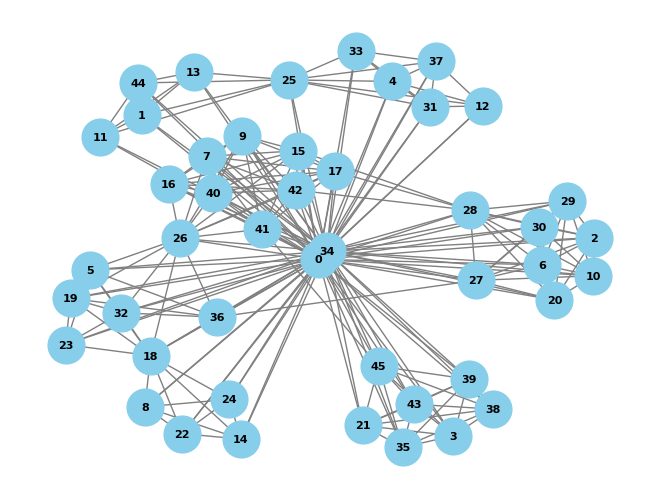

Original Graph Label: 0
Counterfactual Graph:


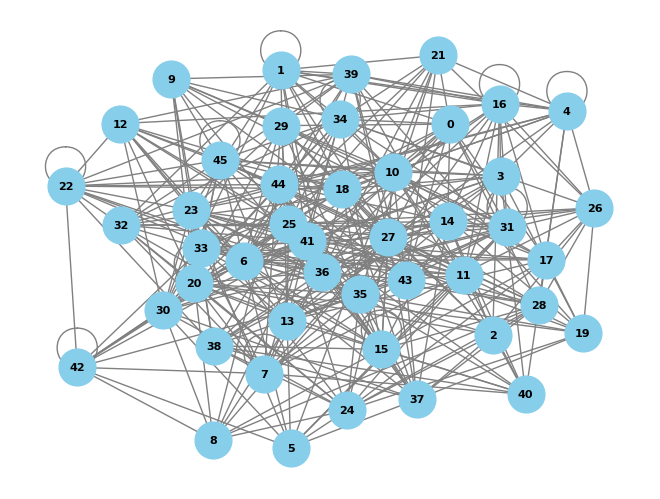

Counterfactual Graph Label: 0


In [ ]:
# Select an individual graph for counterfactual generation
selected_data = next(iter(loader))

# Generate a counterfactual graph
counterfactual_data = generate_counterfactual(selected_data, oracle, perturbation_ratio=0.2, max_iterations=1000, threshold=0.3)

# Visualize the original and counterfactual graphs
print("Original Graph:")
visualize_graph(selected_data.edge_index, selected_data.batch)
print(f"Original Graph Label: {selected_data.y.item()}")
print("Counterfactual Graph:")
visualize_graph(counterfactual_data.edge_index, counterfactual_data.batch)
print(f"Counterfactual Graph Label: {counterfactual_data.y.item()}")

# Graph Visualization with Edge Modifications Function

The following code defines a function for visualizing graphs with edge modifications, distinguishing between added, removed, and unchanged edges.



## Function Parameters
* ```original_edge_index```: The original edge index tensor representing the edges of the graph.
* ```modified_edge_index```: The modified edge index tensor representing the edges of the counterfactual graph.
* ```batch```: The batch tensor specifying the assignment of nodes to different graphs.



## Visualization Process
The function creates two NetworkX graphs based on the original and modified edge indices. Added and removed edges are identified, and a new graph is created to represent the modifications. The modification graph is visualized, with added edges in green, removed edges in red, and unchanged edges in black.

In [ ]:
def visualize_graph_with_modifications(original_edge_index, modified_edge_index, batch):
  """
    Visualizes graphs with edge modifications, distinguishing added, removed, and unchanged edges.

    Parameters:
    - original_edge_index (torch.Tensor): The original edge index tensor of the graph.
    - modified_edge_index (torch.Tensor): The modified edge index tensor of the graph.
    - batch (torch.Tensor): The batch tensor specifying the assignment of nodes to graphs.
  """
  original_graph = nx.Graph()
  modified_graph = nx.Graph()

  # Add edges from the original and modified edge indices
  original_graph.add_edges_from(original_edge_index.t().tolist())
  modified_graph.add_edges_from(modified_edge_index.t().tolist())

  # Create a new graph to store the modifications
  modification_graph = nx.Graph()

  # Identify added and removed edges
  added_edges = modified_graph.edges - original_graph.edges
  removed_edges = original_graph.edges - modified_graph.edges

  # Add edges with appropriate attributes
  for edge in added_edges:
    modification_graph.add_edge(edge[0], edge[1], color='green', linestyle='solid')

  for edge in removed_edges:
    modification_graph.add_edge(edge[0], edge[1], color='red', linestyle='dashed')

  for edge in original_graph.edges:
    if edge not in added_edges and edge not in removed_edges:
      modification_graph.add_edge(edge[0], edge[1], color='black', linestyle='solid')

  # Plot the modification graph
  pos = nx.spring_layout(modification_graph)
  edges = modification_graph.edges()
  colors = [modification_graph[u][v]['color'] for u, v in edges]
  styles = [modification_graph[u][v]['linestyle'] for u, v in edges]

  nx.draw(modification_graph, pos, with_labels=True, font_weight='bold',
          node_size=700, node_color='skyblue', font_size=8, edge_color=colors, style=styles)

  plt.show()


# Example: Visualizing Original and Counterfactual Graphs with Edge Modifications

In this example, the original and counterfactual graphs are visualized, highlighting edge modifications.



Original Graph:


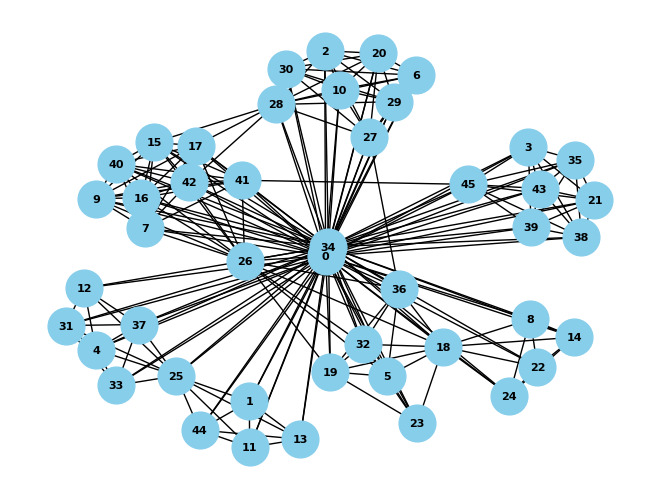

Counterfactual Graph:


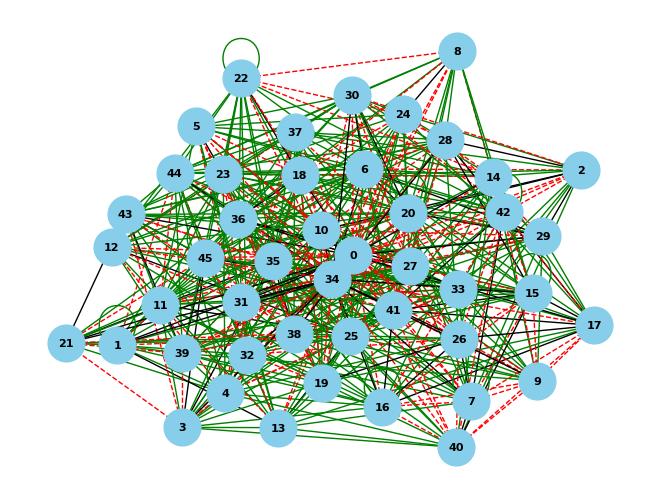

In [ ]:
# Example: Visualize the original and counterfactual graphs with edge modifications
print("Original Graph:")
visualize_graph_with_modifications(selected_data.edge_index, selected_data.edge_index, selected_data.batch)

print("Counterfactual Graph:")
visualize_graph_with_modifications(selected_data.edge_index, counterfactual_data.edge_index, selected_data.batch)

## Visualization Process

The ```visualize_graph_with_modifications``` function is called to visualize both the original and counterfactual graphs with highlighted edge modifications.
The original graph is visualized with no modifications (all edges in black).
The counterfactual graph is visualized with added edges in green, removed edges in red, and unchanged edges in black.

** Note:
Ensure that the edge indices and batch tensor are appropriately formatted based on your graph representation. Adjustments may be needed based on the characteristics of your graphs. This visualization provides a clear representation of how the counterfactual graph differs from the original graph in terms of edge modifications.**